# CIFAR vectorized LiRA example

This notebook mirrors A_cifar_main.ipynb but configures the LiRA attack to use the vectorized fast path.

It is safer to delete previous results for target and shadow models as it will train new models. 


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

train_config_path = "train_robust.yaml"
audit_config_path = "audit_robust.yaml"


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [2]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

data_root = train_config["data"]["data_dir"]
data_path = os.path.join(os.getcwd(), data_root)

# Load the CIFAR train and test datasets
if train_config["data"]["dataset"] == "cifar10":
    trainset = CIFAR10(root=data_root, train=True, download=True)
    testset = CIFAR10(root=data_root, train=False, download=True)
elif train_config["data"]["dataset"] == "cifar100":
    trainset = CIFAR100(root=data_root, train=True, download=True)
    testset = CIFAR100(root=data_root, train=False, download=True)
else:
    raise ValueError("Unknown dataset type")

train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255

# Ensure train and test data looks correct
assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
assert train_data.shape[1] == 3, "Data should have 3 channels"
assert test_data.shape[1] == 3, "Data should have 3 channels"
assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"

# Concatenate train and test data into the population
data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
# Create UserDataset object
population_dataset = CifarInputHandler.UserDataset(data, targets)

assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"

# Store the population dataset to be used by LeakPro 
dataset_name = train_config["data"]["dataset"]
file_path =  data_root+"/"+ dataset_name + ".pkl"
if not os.path.exists(file_path):
    with open(file_path, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {file_path}")
        


With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size) 
test_size = int(test_fraction * dataset_size)
print(f"original train size: {len(train_data)}, test size: {len(test_data)}")
print(f"selected train size: {train_size}, test size: {test_size}")

randomize_audit = False
selected_index = np.arange(train_size + test_size)
if randomize_audit:
    np.random.shuffle(selected_index)
train_indices = selected_index[:train_size]
test_indices = selected_index[train_size:(train_size+test_size)]

# Now define the new target train and test sets
train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)

# Evaluate mean and variance of the train data
#train_mean = train_subset.mean
#train_std = train_subset.std
#print (f"Train mean: {train_mean}")
#print (f"Train std: {train_std}")


original train size: 50000, test size: 10000
selected train size: 30000, test size: 30000


### Train target model
With the train and test dataloader in place, we train a ResNet18. 
After training, we call LeakPro to create metadata that will be used during auditing.

In [4]:
target_dir = train_config["run"]["log_dir"]
print("target_dir:", target_dir)


target_dir: ./robust/target


In [5]:
from torch import save, optim, nn
from target_model_class import ResNet18, WideResNet

# Train the model
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

# Create instance of target model
#model = ResNet18(num_classes = num_classes)
model =  WideResNet(depth=28, num_classes=num_classes, widen_factor=2)

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
weight_decay = train_config["train"]["weight_decay"]
momentum = train_config["train"]["momentum"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# train target model
train_result = CifarInputHandler().train(dataloader=train_loader,
                            model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            epochs=epochs)


Epoch 1/25: 100%|██████████| 106/106 [00:08<00:00, 11.81it/s, acc=0.3943, loss=1.7106]


Validation loss at epoch 1: 1.5474


Epoch 2/25: 100%|██████████| 106/106 [00:08<00:00, 12.53it/s, acc=0.5584, loss=1.2296]


Validation loss at epoch 2: 1.1909


Epoch 3/25: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.6414, loss=1.0012]


Validation loss at epoch 3: 1.1358


Epoch 4/25: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.7109, loss=0.8185]


Validation loss at epoch 4: 1.0699


Epoch 5/25: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=0.7631, loss=0.6712]


Validation loss at epoch 5: 1.1143


Epoch 6/25: 100%|██████████| 106/106 [00:08<00:00, 12.83it/s, acc=0.8044, loss=0.5604]


Validation loss at epoch 6: 0.8484


Epoch 7/25: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.8370, loss=0.4625]


Validation loss at epoch 7: 0.7824


Epoch 8/25: 100%|██████████| 106/106 [00:08<00:00, 12.67it/s, acc=0.8655, loss=0.3812]


Validation loss at epoch 8: 0.9506


Epoch 9/25: 100%|██████████| 106/106 [00:08<00:00, 12.71it/s, acc=0.8990, loss=0.2954]


Validation loss at epoch 9: 0.7514


Epoch 10/25: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9215, loss=0.2278]


Validation loss at epoch 10: 0.8161


Epoch 11/25: 100%|██████████| 106/106 [00:08<00:00, 12.83it/s, acc=0.9441, loss=0.1630]


Validation loss at epoch 11: 0.8239


Epoch 12/25: 100%|██████████| 106/106 [00:08<00:00, 12.63it/s, acc=0.9560, loss=0.1281]


Validation loss at epoch 12: 0.8383


Epoch 13/25: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.9780, loss=0.0721]


Validation loss at epoch 13: 0.7761


Epoch 14/25: 100%|██████████| 106/106 [00:08<00:00, 12.65it/s, acc=0.9928, loss=0.0286]


Validation loss at epoch 14: 0.7927


Epoch 15/25: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9983, loss=0.0114]


Validation loss at epoch 15: 0.7290


Epoch 16/25: 100%|██████████| 106/106 [00:08<00:00, 12.65it/s, acc=1.0000, loss=0.0031]


Validation loss at epoch 16: 0.7356


Epoch 17/25: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=1.0000, loss=0.0020]


Validation loss at epoch 17: 0.7097


Epoch 18/25: 100%|██████████| 106/106 [00:08<00:00, 12.35it/s, acc=1.0000, loss=0.0017]


Validation loss at epoch 18: 0.7100


Epoch 19/25: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=1.0000, loss=0.0016]


Validation loss at epoch 19: 0.7098


Epoch 20/25: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=1.0000, loss=0.0016]


Validation loss at epoch 20: 0.7029


Epoch 21/25: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=1.0000, loss=0.0016]


Validation loss at epoch 21: 0.7098


Epoch 22/25: 100%|██████████| 106/106 [00:08<00:00, 12.88it/s, acc=1.0000, loss=0.0015]


Validation loss at epoch 22: 0.7021


Epoch 23/25: 100%|██████████| 106/106 [00:08<00:00, 12.84it/s, acc=1.0000, loss=0.0015]


Validation loss at epoch 23: 0.7022


Epoch 24/25: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=1.0000, loss=0.0015]


Validation loss at epoch 24: 0.7028


Epoch 25/25: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=1.0000, loss=0.0015]


Validation loss at epoch 25: 0.7019


In [6]:
# Evaluate on test set
test_result = CifarInputHandler().eval(test_loader, model, criterion)

# Store the model and metadata
model = train_result.model
model.to("cpu")
#with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
with open(target_dir+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                      optimizer = optimizer,
                                      loss_fn = criterion,
                                      dataloader = train_loader,
                                      test_result = test_result,
                                      epochs = epochs,
                                      train_indices = train_indices,
                                      test_indices = test_indices,
                                      dataset_name = dataset_name)

with open(target_dir+"/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)
    

Plot accuracy and test of training and test.

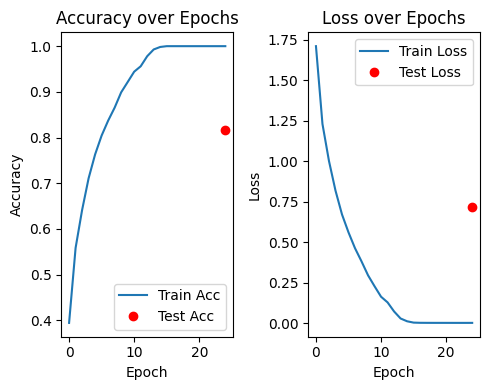

In [19]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Train shadow models

In [8]:
from leakpro.schemas import LeakProConfig

with open(audit_config_path, "rb") as f:
    audit_configs = yaml.safe_load(f)
leakpro_configs = LeakProConfig(**audit_configs)


In [9]:
shadow_dir = audit_configs["audit"]["output_dir"]
print("shadow_dir:", shadow_dir)


shadow_dir: ./robust/output


In [10]:
import numpy as np

from leakpro.attacks.mia_attacks.lira import AttackLiRA
from leakpro.attacks.utils.shadow_model_handler import ShadowModelHandler
#from shadow_model_handler import ShadowModelHandler # less verbose
from leakpro.input_handler.mia_handler import MIAHandler

from cifar_handler import CifarInputHandler

# Create the handler, it mostly serves as a dummy handler needed to init the attack but it also creates a dataloader,
# contains the metadata for creating the attack and how shadow models are created for example.

handler = MIAHandler(leakpro_configs, CifarInputHandler)

#configs = handler.configs.audit.attack_list[0] 
for configs in handler.configs.audit.attack_list:
    if configs["attack"] == "lira" and configs["online"]== True:        
        print(f'found online lira attack')
        attack = AttackLiRA(handler=handler, configs=configs)
        break
    else:
        print(f'attack {configs["attack"]} is not lira')
        attack = None

assert configs["attack"]=='lira', "ERROR: attack must be lira"
assert configs["online"]== True, "ERROR: attack must online"


2025-11-01 15:10:50,365 INFO     Target model blueprint created from WideResNet in ./target_model_class.py.
11/01/2025 15:10:50:INFO:Target model blueprint created from WideResNet in ./target_model_class.py.
2025-11-01 15:10:50,399 INFO     Loaded target model metadata from ./robust/target/model_metadata.pkl
11/01/2025 15:10:50:INFO:Loaded target model metadata from ./robust/target/model_metadata.pkl
2025-11-01 15:10:50,456 INFO     Loaded target model from ./robust/target
11/01/2025 15:10:50:INFO:Loaded target model from ./robust/target
2025-11-01 15:10:51,400 INFO     Loaded population dataset from ./data/cifar10.pkl
11/01/2025 15:10:51:INFO:Loaded population dataset from ./data/cifar10.pkl


found online lira attack


In [11]:
# Get attack data indices. If true, the whole population is used, otherwise exclude the training data.
attack_data_indices = attack.sample_indices_from_population(include_train_indices = True, include_test_indices = True)

training_data_fraction = attack.training_data_fraction # Use the same fraction as the target model


In [12]:
#Set number of shadow models to train
num_shadow_models = configs["num_shadow_models"]

# Train shadow models
#print("Note that incremental is set to ", INCREMENTAL)
#print("Note that shuffle_shift is set to ", SHUFFLE_SHIFT)
shadow_model_indices = ShadowModelHandler(handler).create_shadow_models(num_models = num_shadow_models,
                                                                shadow_population =  attack_data_indices,
                                                                training_fraction = training_data_fraction,
                                                                online = True, 
                                                                #verbose = False,
                                                                #incremental = INCREMENTAL, 
                                                                #shuffle_shift = SHUFFLE_SHIFT
                                                                       )


2025-11-01 15:10:51,459 INFO     Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
11/01/2025 15:10:51:INFO:Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
2025-11-01 15:10:51,777 INFO     Number of existing models exceeds or equals the number of models to create
11/01/2025 15:10:51:INFO:Number of existing models exceeds or equals the number of models to create


In [13]:
# Get the signal function from the attack like this
#signal = attack.signal

# Set the batch size we want to use for the signal function to extract signals faster
attack.handler.dataloader_config.params["batch_size"] = 1024

# Extract our logits
#target_models_logits = np.swapaxes(signal([attack.target_model],
#                                    attack.handler,
#                                    audit_dataset["data"],
#                                ), 0, 1).squeeze()

#print("target_models_logits", target_models_logits.shape)

attack.prepare_attack()

print(attack.shadow_models_logits.shape, attack.target_logits.shape)


2025-11-01 15:10:52,102 INFO     Number of existing models exceeds or equals the number of models to create
11/01/2025 15:10:52:INFO:Number of existing models exceeds or equals the number of models to create
2025-11-01 15:10:52,104 INFO     Loading shadow model 0
11/01/2025 15:10:52:INFO:Loading shadow model 0
2025-11-01 15:10:52,172 INFO     Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_0.pkl
11/01/2025 15:10:52:INFO:Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_0.pkl
2025-11-01 15:10:52,174 INFO     Loading shadow model 1
11/01/2025 15:10:52:INFO:Loading shadow model 1
2025-11-01 15:10:52,242 INFO     Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_1.pkl
11/01/2025 15:10:52:INFO:Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_1.pkl
2025-11-01 15:10:52,244 INFO     Loading shadow model 2
11/01/2025 15:10:52:INFO:Loading shadow model 2
2025-11-01 15:10:52,331 INFO     Loaded 

(20, 60000) (60000,)


In [14]:
# Get the audit dataset from the attack
audit_dataset = attack.audit_dataset
audit_data_indices = audit_dataset["data"]

# Reconstruct the audit data indices array
target_audit_data_indices = np.concatenate([train_indices, test_indices])
assert all(audit_data_indices == target_audit_data_indices)


In [15]:
# Now create in indices mask for target model compliant with those for shadow
target_in_indices_mask = np.zeros_like(target_audit_data_indices)
target_in_indices_mask[:len(train_indices)] = 1
target_in_indices_mask = target_in_indices_mask.astype(bool)
target_in_indices_mask


array([ True,  True,  True, ..., False, False, False], shape=(60000,))

In [16]:
# Get in indices mask for shadow models 

in_indices_masks = ShadowModelHandler(handler).get_in_indices_mask(shadow_model_indices, audit_dataset["data"])#.astype(int)


2025-11-01 15:10:57,449 INFO     Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
11/01/2025 15:10:57:INFO:Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
2025-11-01 15:10:57,451 INFO     Loading metadata 0
11/01/2025 15:10:57:INFO:Loading metadata 0
2025-11-01 15:10:57,470 INFO     Loading metadata 1
11/01/2025 15:10:57:INFO:Loading metadata 1
2025-11-01 15:10:57,488 INFO     Loading metadata 2
11/01/2025 15:10:57:INFO:Loading metadata 2
2025-11-01 15:10:57,507 INFO     Loading metadata 3
11/01/2025 15:10:57:INFO:Loading metadata 3
2025-11-01 15:10:57,525 INFO     Loading metadata 4
11/01/2025 15:10:57:INFO:Loading metadata 4
2025-11-01 15:10:57,543 INFO     Loading metadata 5
11/01/2025 15:10:57:INFO:Loading metadata 5
2025-11-01 15:10:57,561 INFO     Loading metadata 6
11/01/2025 15:10:57:INFO:Loading metadata 6
2025-11-01 15:10:57,579 INFO     Loading metadata 7
11/01/2025 15:10:57:INFO:Loading metadata 7
2025

In [17]:
filepath = target_dir + "/signals"
os.makedirs(filepath, exist_ok=True)

print("store target results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", attack.target_logits[:,None]) # make it 2D array
np.save(filepath + "/in_indices_masks.npy", target_in_indices_mask[:,None]) #  make it 2D array
np.save(filepath + "/audit_data_indices.npy", target_audit_data_indices)

print("attack.target_logits", attack.target_logits.shape)
print("target_in_indices_mask", target_in_indices_mask.shape)


store target results in  ./robust/target/signals
attack.target_logits (60000,)
target_in_indices_mask (60000,)


In [18]:
filepath = shadow_dir + "/signals"
os.makedirs(filepath, exist_ok=True)

print("store shadow results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", attack.shadow_models_logits.T)
np.save(filepath + "/in_indices_masks.npy", in_indices_masks)
np.save(filepath + "/audit_data_indices.npy", audit_data_indices)

print("shadow_models_logits", attack.shadow_models_logits.shape)
print("in_indices_masks", in_indices_masks.shape)


store shadow results in  ./robust/output/signals
shadow_models_logits (20, 60000)
in_indices_masks (60000, 20)
